In [4]:
#데이터 핸들링 라이브러리
import pandas as pd
import numpy as np
#데이터 시각화 라이브러리
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams.update({'font.family':'AppleGothic'})
mpl.rc('axes', unicode_minus=False)
%config InlineBackend.figure_format = 'retina'

## 데이터 전처리 계획
1. 데이터 불러오기, 결측치 처리하기
2. 상대적으로 중요성이 떨어져보이는 피처 삭제, 필요하면 피처명을 직관적으로 다시 네이밍하기
3. 비숫자-문자열 독립변수 인코딩하기
4. 데이터 정규화
5. 훈련-테스트셋 분리

## 모델 학습 계획
1. 모델 생성
2. Cross_validation을 통한 모델학습
3. Accuracy, Precision,Recall, ROC 4개의 지표로 분류모델의 정확도 평가하기

In [5]:
#1. 데이터 불러오기 from TAAS: http://taas.koroad.or.kr/web/shp/sbm/initGisAnals.do?menuId=WEB_KMP_GIS_TAS
## 해당 경로에 있는 .csv 파일명 리스트 가져오기

import os
import time
t_0= time.time()

path = '../교통사고_2021/'
file_list = os.listdir(path)
file_list_py = [file for file in file_list if file.endswith('.xls')] ## 파일명 끝이 .xls인 경우

## csv 파일들을 DataFrame으로 불러와서 concat

death_df_org = pd.DataFrame()
for i in file_list_py:
    data = pd.read_html(path + i)
    data= data[0]
    death_df_org = pd.concat([death_df_org,data])

death_df_org = death_df_org.reset_index(drop = True)
print(f'데이터 불러오기 및 통합에 걸린 시간은 {str(time.time()-t_0)} 입니다')
death_df= death_df_org.copy()

데이터 불러오기 및 통합에 걸린 시간은 30.622768878936768 입니다


In [6]:
"""
결측치 확인하기 => 피해운전자의 차종,성별,연령,상해정도를 파악하지 못하는 데이터가 6687건이 존재함
원본데이터 194094에 비하면 삭제해도 학습에 영향력을 크게 미치지 못할 뿐더러, 이러한 데이터들이
특정 편향성을 갖고 존재할 것이라 보기 어렵다(아마도 기록 누락에 의해 이러한 데이터가 존재할 것이기 때문)
그렇기 때문에 데이터를 제거해도 될것이라 판단하였음
"""
death_df.isnull().sum()
death_df.dropna(inplace=True)
death_df.isnull().sum()

사고번호          0
사고일시          0
요일            0
시군구           0
사고내용          0
사망자수          0
중상자수          0
경상자수          0
부상신고자수        0
사고유형          0
법규위반          0
노면상태          0
기상상태          0
도로형태          0
가해운전자 차종      0
가해운전자 성별      0
가해운전자 연령      0
가해운전자 상해정도    0
피해운전자 차종      0
피해운전자 성별      0
피해운전자 연령      0
피해운전자 상해정도    0
dtype: int64

In [7]:
#데이터 정보 찾기
print(death_df.info())
death_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 187407 entries, 2 to 194093
Data columns (total 22 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   사고번호        187407 non-null  int64 
 1   사고일시        187407 non-null  object
 2   요일          187407 non-null  object
 3   시군구         187407 non-null  object
 4   사고내용        187407 non-null  object
 5   사망자수        187407 non-null  int64 
 6   중상자수        187407 non-null  int64 
 7   경상자수        187407 non-null  int64 
 8   부상신고자수      187407 non-null  int64 
 9   사고유형        187407 non-null  object
 10  법규위반        187407 non-null  object
 11  노면상태        187407 non-null  object
 12  기상상태        187407 non-null  object
 13  도로형태        187407 non-null  object
 14  가해운전자 차종    187407 non-null  object
 15  가해운전자 성별    187407 non-null  object
 16  가해운전자 연령    187407 non-null  object
 17  가해운전자 상해정도  187407 non-null  object
 18  피해운전자 차종    187407 non-null  object
 19  피해운전자 성별    187407 non-

,사고번호,사고일시,요일,시군구,사고내용,사망자수,중상자수,경상자수,부상신고자수,사고유형,...,기상상태,도로형태,가해운전자 차종,가해운전자 성별,가해운전자 연령,가해운전자 상해정도,피해운전자 차종,피해운전자 성별,피해운전자 연령,피해운전자 상해정도
2,2021010100100040,2021년 1월 1일 08시,금요일,강원도 강릉시 강문동,중상사고,0,1,0,0,차대사람 - 횡단중,...,맑음,단일로 - 기타,화물,남,53세,상해없음,보행자,여,20세,중상
3,2021010100100065,2021년 1월 1일 11시,금요일,강원도 강릉시 옥계면,경상사고,0,0,4,0,차대차 - 측면충돌,...,맑음,교차로 - 교차로안,승용,남,43세,상해없음,화물,남,49세,경상
4,2021010100100089,2021년 1월 1일 13시,금요일,강원도 동해시 천곡동,경상사고,0,0,2,0,차대차 - 측면충돌,...,맑음,단일로 - 기타,승용,남,62세,상해없음,승용,남,24세,경상
5,2021010100100123,2021년 1월 1일 15시,금요일,강원도 강릉시 포남동,사망사고,1,0,0,0,차대차 - 측면충돌,...,맑음,교차로 - 교차로안,원동기,남,16세,상해없음,승용,여,50세,상해없음
6,2021010100100146,2021년 1월 1일 17시,금요일,강원도 강릉시 옥천동,경상사고,0,0,2,0,차대차 - 추돌,...,맑음,교차로 - 교차로부근,승용,여,33세,상해없음,승용,남,27세,경상


## 종속변수의 카테고리 비율 확인하기
- 전체 교통사고중 사망사고의 비율은 약 1.15%로, 낮은 비율을 차지하고 있다

In [8]:
print(death_df['사고내용'].value_counts())
ratio=2149/(138186+47072+2149)
print(f'전체 사고중 사망사고의 비율은 {str(ratio)} 입니다')

경상사고    138186
중상사고     47072
사망사고      2149
Name: 사고내용, dtype: int64
전체 사고중 사망사고의 비율은 0.0114670209757373 입니다


## 컬럼 핸들링하기
- 불필요해보이는 컬럼 제거하기
    1. 사고번호는 각 사고에 대해 일대일 대응되는 key값으로 나중에 데이터를 결합시키는데 사용될 수 있어 보이나, 일단
    지금 당장 사용되지 않으므로 삭제한다
    2. 사망자수,중상자수,경상자수,부상신고자는 '피해운전자 상해정도'에 필요한 정보가 담겨있으므로 삭제한다
    3. 위치정보는 사용하지 않으므로 시군구도 삭제한다
- 종속변수 '사고내용'에서 사망자를 1, 중상,경상을 0으로 하는 새로운 종속변수열을 만들기
- 발생년월시에서 시간만 떼어내고, 정수형으로 데이터 변환하고, 22~06시를 야간, 그외 시간을 주간으로 분류하는 데이터 프레임 열 만들기
- 피해운전자, 가해운전자 연령에서 '세' 단위 떼어내고 정수형으로 데이터 변환하기

In [9]:
# 경상,중상사고는 0, 사망사고는 1로 라벨링한다
index1= death_df['사고내용']=='사망사고'
death_df['사망사고여부']=index1
death_df


,사고번호,사고일시,요일,시군구,사고내용,사망자수,중상자수,경상자수,부상신고자수,사고유형,...,도로형태,가해운전자 차종,가해운전자 성별,가해운전자 연령,가해운전자 상해정도,피해운전자 차종,피해운전자 성별,피해운전자 연령,피해운전자 상해정도,사망사고여부
2,2021010100100040,2021년 1월 1일 08시,금요일,강원도 강릉시 강문동,중상사고,0,1,0,0,차대사람 - 횡단중,...,단일로 - 기타,화물,남,53세,상해없음,보행자,여,20세,중상,False
3,2021010100100065,2021년 1월 1일 11시,금요일,강원도 강릉시 옥계면,경상사고,0,0,4,0,차대차 - 측면충돌,...,교차로 - 교차로안,승용,남,43세,상해없음,화물,남,49세,경상,False
4,2021010100100089,2021년 1월 1일 13시,금요일,강원도 동해시 천곡동,경상사고,0,0,2,0,차대차 - 측면충돌,...,단일로 - 기타,승용,남,62세,상해없음,승용,남,24세,경상,False
5,2021010100100123,2021년 1월 1일 15시,금요일,강원도 강릉시 포남동,사망사고,1,0,0,0,차대차 - 측면충돌,...,교차로 - 교차로안,원동기,남,16세,상해없음,승용,여,50세,상해없음,True
6,2021010100100146,2021년 1월 1일 17시,금요일,강원도 강릉시 옥천동,경상사고,0,0,2,0,차대차 - 추돌,...,교차로 - 교차로부근,승용,여,33세,상해없음,승용,남,27세,경상,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194089,2021123100100335,2021년 12월 31일 16시,금요일,충청남도 천안시 동남구 광덕면,경상사고,0,0,3,0,차대차 - 측면충돌,...,교차로 - 교차로안,승용,여,32세,경상,승용,남,42세,경상,False
194090,2021123100100383,2021년 12월 31일 17시,금요일,충청남도 부여군 장암면,중상사고,0,1,0,0,차대차 - 추돌,...,단일로 - 기타,승용,남,24세,상해없음,자전거,남,78세,중상,False
194091,2021123100100384,2021년 12월 31일 17시,금요일,충청남도 천안시 동남구 청당동,경상사고,0,0,3,0,차대차 - 측면충돌,...,단일로 - 기타,승용,남,25세,경상,승용,남,22세,경상,False
194092,2021123100100578,2021년 12월 31일 21시,금요일,충청남도 보령시 명천동,경상사고,0,0,1,0,차대차 - 추돌,...,기타 - 기타,승용,남,59세,상해없음,승용,여,28세,경상,False


In [10]:
#불필요해보이는 컬럼 제거
death_df.drop(['사고번호','시군구','사망자수','중상자수',
               '경상자수','부상신고자수','노면상태','가해운전자 상해정도','피해운전자 상해정도','사고내용'],axis=1,inplace=True)

##시간에 따른 시계가 교통사고의 요인중 하나일 수 있으므로 발생년월일시에서 시간만 떼어 새로운 컬럼으로 만듬
time_lst= list(death_df['사고일시'])
hour_lst=[]
for time in time_lst:
    hour_lst.append((str(time)[-3:-1]))
death_df['사고시각']= hour_lst
#사고일시 컬럼은 삭제
death_df.drop(['사고일시'],axis=1,inplace=True)

#피해운전자, 가해운전자 연령 미분류 삭제하기
idx= death_df[death_df['피해운전자 연령']=='미분류'].index
death_df.drop(idx,inplace=True)
idx= death_df[death_df['피해운전자 연령']=='98세 이상'].index
death_df.drop(idx,inplace=True)

idx2= death_df[death_df['가해운전자 연령']=='미분류'].index
death_df.drop(idx2,inplace=True)

#나이 컬럼: 숫자단위만 뽑기
suspect_lst= list(death_df['가해운전자 연령'])
suspect_old= []
for old in suspect_lst:
    suspect_old.append((old)[:-1])

death_df['가해운전자 연령']=suspect_old

victim_lst= list(death_df['피해운전자 연령'])
victim_old= []
for old in victim_lst:
    victim_old.append((old)[:-1])
death_df['피해운전자 연령']=victim_old



In [11]:
index2= death_df['사고시각']=='22','23','24','1','2','3','4','5','6'
death_df['야간여부']=index2[0]
death_df.drop(['사고시각'],axis=1,inplace=True)

In [12]:
death_df=death_df.reindex(columns=['야간여부','사고유형','법규위반','기상상태','도로형태',
                                   '가해운전자 차종','가해운전자 성별','가해운전자 연령',
                                   '피해운전자 차종','피해운전자 성별','피해운전자 연령','사망사고여부'])

In [13]:
#데이터 자료형 변환: 문자열-> 정수형
death_df['가해운전자 연령']=death_df['가해운전자 연령'].astype('int')
death_df['피해운전자 연령']=death_df['피해운전자 연령'].astype('int')

In [14]:
death_df

,야간여부,사고유형,법규위반,기상상태,도로형태,가해운전자 차종,가해운전자 성별,가해운전자 연령,피해운전자 차종,피해운전자 성별,피해운전자 연령,사망사고여부
2,False,차대사람 - 횡단중,보행자보호의무위반,맑음,단일로 - 기타,화물,남,53,보행자,여,20,False
3,False,차대차 - 측면충돌,신호위반,맑음,교차로 - 교차로안,승용,남,43,화물,남,49,False
4,False,차대차 - 측면충돌,기타,맑음,단일로 - 기타,승용,남,62,승용,남,24,False
5,False,차대차 - 측면충돌,안전운전불이행,맑음,교차로 - 교차로안,원동기,남,16,승용,여,50,True
6,False,차대차 - 추돌,안전운전불이행,맑음,교차로 - 교차로부근,승용,여,33,승용,남,27,False
...,...,...,...,...,...,...,...,...,...,...,...,...
194089,False,차대차 - 측면충돌,신호위반,맑음,교차로 - 교차로안,승용,여,32,승용,남,42,False
194090,False,차대차 - 추돌,안전운전불이행,맑음,단일로 - 기타,승용,남,24,자전거,남,78,False
194091,False,차대차 - 측면충돌,안전운전불이행,맑음,단일로 - 기타,승용,남,25,승용,남,22,False
194092,False,차대차 - 추돌,기타,맑음,기타 - 기타,승용,남,59,승용,여,28,False


![](https://scikit-learn.org/stable/_images/multi_org_chart.png)

## 3.범주형 변수 인코딩하기(한번만 인코딩 해야됨 두번하면 안됨)
- 랜덤 포레스트나 트리 기반 알고리즘의 경우 LabelEncdoer를 활용한 인코딩을 하여도 되나, 그 외의 경우 One-Hot Encoding을 하여야 한다
- One-Hot Encoding으로 sklearn에도 모듈이 있지만 pd.get_dummies가 사용편의성이 좋은듯
- [아 졸려](https://blog.roboflow.com/precision-and-recall/#precision-and-recall-examples)

In [15]:
#features=['야간여부','사고유형','법규위반','기상상태','도로형태','가해운전자 차종','피해운전자 차종','사망사고여부']
features=['야간여부','사고유형','법규위반','기상상태','도로형태',
         '가해운전자 차종','가해운전자 성별',
         '피해운전자 차종','피해운전자 성별','사망사고여부']
encoded_df_org= pd.get_dummies(data=death_df,columns=features,prefix=features)
encoded_df=encoded_df_org.copy()



In [16]:
#데이터 분리시키기
y=encoded_df['사망사고여부_True']
X=encoded_df.drop(['사망사고여부_True','사망사고여부_False'],axis=1)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train,y_test= train_test_split(X,y,test_size=0.2)

#X_train,y_train을 다시 학습과 검증 데이터셋으로 분리
X_tr,X_val, y_tr,y_val =train_test_split(X_train,y_train,test_size=0.3,random_state=0)

## 머신러닝 모듈 정리해두기

In [17]:
""""Binarizer: 문턱값(threshold)를 설정하여 그 이상값을 입력받으면 1을, 아니면 0을 반환하는 함수.
보통 pred_proba란 함수가 특정 카테고리에 대한 확률값을 제공하는 함수인데, 지금 이 예제와 같이 y의 0과 1의 비율이 크게 차이가
나는 경우 1에 대한 예측 확률이 크게 작다. 원래는 1에 대한 pred_proba 예측이 0.5이상 일때 1을 예측하는데, Binarizer를 통해
1을 예측하기 위한 확률 문턱값을 낮출수 있고, 그를 통해 재현율(실제 1일일때 1을 예측하는 비율)을 높일 수 있다"""
from sklearn.preprocessing import Binarizer

#GridSearchCV 라이브러리(HyperParameter를 일일히 대입하여 최적의 파라미터를 찾는 알고리즘)
from sklearn.model_selection import GridSearchCV

#머신러닝 성능 지표 관련 라이브러리
from sklearn.metrics import accuracy_score,precision_score,roc_auc_score,recall_score

#머신러닝 Gradient Boost 계열 라이브러리
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


In [19]:
#모델1. XGBclassifier

from xgboost import XGBClassifier

# n_estimators 는 500, random_state는 예제 수행시마다 동일 예측 결과를 위해 설정한다
xgb_clf= XGBClassifier(n_estimators=300,learning_rate=0.05)

#성능 평가 지표를 auc로, 조기 중단 파라미터를 100으로 설정하고 학습을 수행시킨다
xgb_clf.fit(X_tr,y_tr,early_stopping_rounds=100,eval_metric='auc',eval_set=[(X_tr,y_tr),(X_val,y_val)])

#ROC의 정의: ROC, X축이 FPR( FP/(FP+TN), 음성인 것들의 수에서 양성이라 잘못 예측한 것의 비),
# 축은 TNR( TP/(FN+TP), 양성 중에서 양성이라 올바로 예측한 것의 비)
#ROC_AUC(Area Under Curve)는 보통 0.7이상이면 그럭저럭 괜찮고 0.8이면 좋은 모델이라 볼 수 있다

#모델 평가
roc_val= roc_auc_score(y_test,xgb_clf.predict_proba(X_test)[:,1])
recall_val= recall_score(y_test,xgb_clf.predict(X_test))
accuracy_val= accuracy_score(y_test,xgb_clf.predict(X_test))
precision_val= precision_score(y_test,xgb_clf.predict(X_test))
print('\n--------------------------------------')
print(f'ROC_AUC는 {roc_val} 입니다')
print(f'recall_score는 {recall_val} 입니다')
print(f'precision_score는 {precision_val} 입니다')
print(f'accuracy_score는 {accuracy_val} 입니다')
print('--------------------------------------')
#recall_score가 0.036231884057971016: 대부분을 사망안함 0으로 예측안함으로 다른 지표값들을 높여서 이런 현상이 발생했을 가능성이 높음

/Users/wooseongkyun/miniforge3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/wooseongkyun/miniforge3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/wooseongkyun/miniforge3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(d

[0]	validation_0-auc:0.77074	validation_1-auc:0.79237
[1]	validation_0-auc:0.77097	validation_1-auc:0.79327
[2]	validation_0-auc:0.77440	validation_1-auc:0.79681
[3]	validation_0-auc:0.77816	validation_1-auc:0.79834
[4]	validation_0-auc:0.77790	validation_1-auc:0.79844
[5]	validation_0-auc:0.78049	validation_1-auc:0.79905
[6]	validation_0-auc:0.79765	validation_1-auc:0.80569
[7]	validation_0-auc:0.79938	validation_1-auc:0.80637
[8]	validation_0-auc:0.81315	validation_1-auc:0.81289
[9]	validation_0-auc:0.81392	validation_1-auc:0.81305
[10]	validation_0-auc:0.81819	validation_1-auc:0.81528
[11]	validation_0-auc:0.81933	validation_1-auc:0.81529
[12]	validation_0-auc:0.81987	validation_1-auc:0.81496
[13]	validation_0-auc:0.82064	validation_1-auc:0.81633
[14]	validation_0-auc:0.82456	validation_1-auc:0.81599
[15]	validation_0-auc:0.82497	validation_1-auc:0.81620
[16]	validation_0-auc:0.82583	validation_1-auc:0.81650
[17]	validation_0-auc:0.82595	validation_1-auc:0.81635
[18]	validation_0-au

/Users/wooseongkyun/miniforge3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/wooseongkyun/miniforge3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/wooseongkyun/miniforge3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [22]:
#모델1-2. XGBclassifier - Binarizer를 적용한다

# n_estimators 는 300, random_state는 예제 수행시마다 동일 예측 결과를 위해 설정한다
xgb_clf= XGBClassifier(n_estimators=300,learning_rate=0.05)

#성능 평가 지표를 auc로, 조기 중단 파라미터를 100으로 설정하고 학습을 수행시킨다
xgb_clf.fit(X_tr,y_tr,early_stopping_rounds=100,eval_metric='auc',eval_set=[(X_tr,y_tr),(X_val,y_val)])

#ROC의 정의: ROC, X축이 FPR( FP/(FP+TN), 음성인 것들의 수에서 양성이라 잘못 예측한 것의 비),
# 축은 TNR( TP/(FN+TP), 양성 중에서 양성이라 올바로 예측한 것의 비)
#ROC_AUC(Area Under Curve)는 보통 0.7이상이면 그럭저럭 괜찮고 0.8이면 좋은 모델이라 볼 수 있다

#Binarizer 적용하기
custom_threshold= 0.01
pred_proba_1= xgb_clf.predict_proba(X_test)[:,1].reshape(-1,1)
binarizer= Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict= binarizer.transform(pred_proba_1)

#모델 평가
roc_val= roc_auc_score(y_test,y_pred_proba)
recall_val= recall_score(y_test,custom_predict)
accuracy_val= accuracy_score(y_test,custom_predict)
precision_val= precision_score(y_test,custom_predict)

print('\n--------------------------------------')
print(f'ROC_AUC는 {roc_val} 입니다')
print(f'recall_score는 {recall_val} 입니다')
print(f'precision_score는 {precision_val} 입니다')
print(f'accuracy_score는 {accuracy_val} 입니다')
print('--------------------------------------')
#recall_score가 0.036231884057971016: 대부분을 사망안함 0으로 예측안함으로 다른 지표값들을 높여서 이런 현상이 발생했을 가능성이 높음

[0]	validation_0-auc:0.77141	validation_1-auc:0.75851


/Users/wooseongkyun/miniforge3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/wooseongkyun/miniforge3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[1]	validation_0-auc:0.77093	validation_1-auc:0.75866
[2]	validation_0-auc:0.77869	validation_1-auc:0.76636
[3]	validation_0-auc:0.78487	validation_1-auc:0.77652
[4]	validation_0-auc:0.78882	validation_1-auc:0.78177
[5]	validation_0-auc:0.79225	validation_1-auc:0.78328
[6]	validation_0-auc:0.79218	validation_1-auc:0.78333
[7]	validation_0-auc:0.79677	validation_1-auc:0.78900
[8]	validation_0-auc:0.79777	validation_1-auc:0.79034
[9]	validation_0-auc:0.81132	validation_1-auc:0.79937
[10]	validation_0-auc:0.81295	validation_1-auc:0.80021
[11]	validation_0-auc:0.81434	validation_1-auc:0.80059
[12]	validation_0-auc:0.81480	validation_1-auc:0.80070
[13]	validation_0-auc:0.81493	validation_1-auc:0.80058
[14]	validation_0-auc:0.81542	validation_1-auc:0.80103
[15]	validation_0-auc:0.81533	validation_1-auc:0.80111
[16]	validation_0-auc:0.82758	validation_1-auc:0.81033
[17]	validation_0-auc:0.82784	validation_1-auc:0.81019
[18]	validation_0-auc:0.82841	validation_1-auc:0.81057
[19]	validation_0-a

/Users/wooseongkyun/miniforge3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/wooseongkyun/miniforge3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


변환된 분류 결정 임계값 배열의 shape: (32470,)


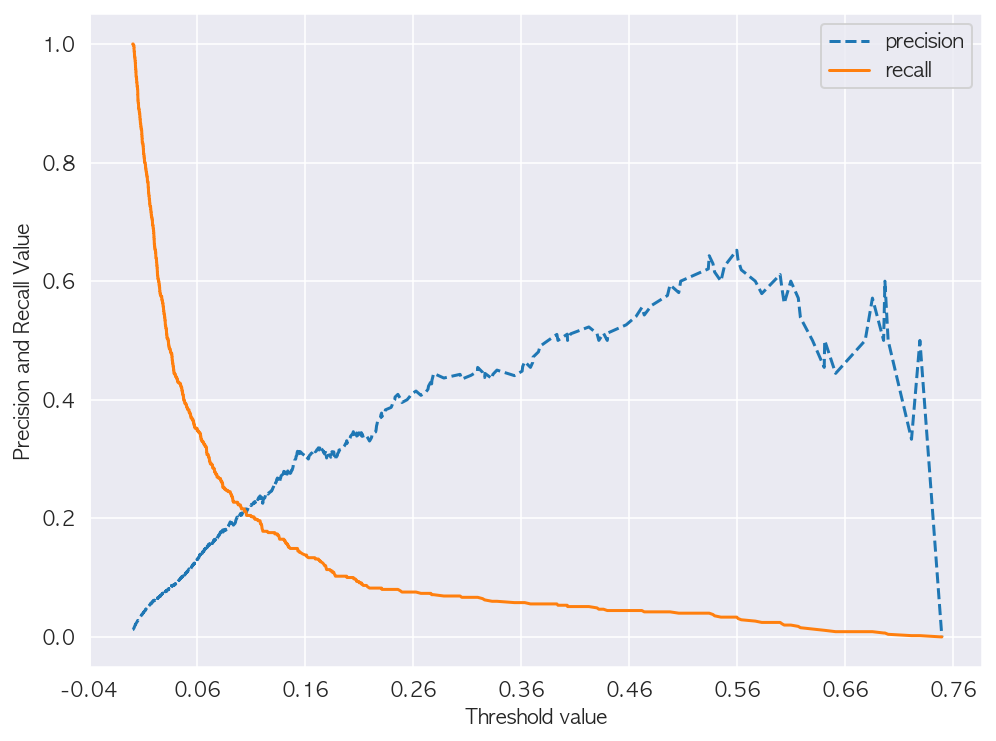

In [27]:
#모델 1-3. Precision-Recall Curve 시각화

from sklearn.metrics import precision_recall_curve

#레이블 값이 1일때의 예측확률을 추출
pred_proba_class1=xgb_clf.predict_proba(X_test)[:,1]

#실제값 데이터 셋과 레이블 값이 1일때의 예측 확률을 precision_recall_curve 인자로 입력한다
precisions, recalls, thresholds= precision_recall_curve(y_test,pred_proba_class1)
print(f'변환된 분류 결정 임계값 배열의 shape:',thresholds.shape)

#임계값을 thresholds.shape[0] // 50으로 하자
thr_index= np.arange(0,thresholds.shape[0],thresholds.shape[0]//50)
# print(f'샘플 추출을 위한 임계값 배열의 index 20개 {thr_index}')
# print(f'샘플용 20개 임계값 {np.round(thresholds[thr_index],2)}')
#
# # thresholds.shape[0] // 50 스텝 단위로 추출된 임계값에 따른 정밀도와 재현율 값
# print(f'샘플 임계값별 정밀도 {np.round(precisions[thr_index],3)}')
# print(f'샘플 임계값별 재현율 {np.round(recalls[thr_index],3)}')

def precision_recall_curve_plot(y_test,pred_proba_c1):
    #threshold array와 이 threshold에 따른 정밀도, 재현율을 반환한다
    precisions, recalls, thresholds= precision_recall_curve(y_test,pred_proba_c1)

    #x축을 threshold값으로, y축을 정밀도, 재현율 값으로 각각 plot을 수행한다. 정밀도는 점선으로 표기한다
    plt.figure(figsize=(8,6))
    threshold_boundary= thresholds.shape[0]
    plt.plot(thresholds,precisions[0:threshold_boundary],linestyle='--',label='precision')
    plt.plot(thresholds,recalls[0:threshold_boundary],label='recall')

    #thresholds 값 X축의 scale을 0.1 단위로 변경한다
    start, end= plt.xlim()
    plt.xticks(np.round(np.arange(start,end,0.1),2))

    #x축, y축, label과 legend, 그리고 grid를 설정한다
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall Value')
    plt.legend(loc='best')
    plt.show()

precision_recall_curve_plot(y_test,xgb_clf.predict_proba(X_test)[:,1])

In [21]:
#모델2. LightGBMClassifier
from lightgbm import LGBMClassifier

lgbm_cf= LGBMClassifier(n_estimators=400, learning_rate=0.05)
#lightGBM도 XGBoost와 마찬가지로 조기 중단 수행이 가능하다
evals=[(X_tr,y_tr),(X_val,y_val)]
lgbm_cf.fit(X_tr,y_tr,early_stopping_rounds=50, eval_metric='logloss',eval_set=evals,verbose=True)
y_pred= lgbm_cf.predict(X_test)
pred_proba= lgbm_cf.predict_proba(X_test)[:,1]

#모델 평가
roc_val= roc_auc_score(y_test,y_pred)
recall_val= recall_score(y_test,y_pred)
accuracy_val= accuracy_score(y_test,y_pred)
precision_val= precision_score(y_test,y_pred)

print('\n--------------------------------------')
print(f'ROC_AUC는 {roc_val} 입니다')
print(f'recall_score는 {recall_val} 입니다')
print(f'precision_score는 {precision_val} 입니다')
print(f'accuracy_score는 {accuracy_val} 입니다')
print('--------------------------------------')

/Users/wooseongkyun/miniforge3/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/wooseongkyun/miniforge3/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	training's binary_logloss: 0.059982	valid_1's binary_logloss: 0.0601226
[2]	training's binary_logloss: 0.0585812	valid_1's binary_logloss: 0.0591987
[3]	training's binary_logloss: 0.0575779	valid_1's binary_logloss: 0.0584372
[4]	training's binary_logloss: 0.0567027	valid_1's binary_logloss: 0.05781
[5]	training's binary_logloss: 0.0559288	valid_1's binary_logloss: 0.0572029
[6]	training's binary_logloss: 0.0552388	valid_1's binary_logloss: 0.0566606
[7]	training's binary_logloss: 0.0546377	valid_1's binary_logloss: 0.0561928
[8]	training's binary_logloss: 0.0540953	valid_1's binary_logloss: 0.0557939
[9]	training's binary_logloss: 0.0536138	valid_1's binary_logloss: 0.055399
[10]	training's binary_logloss: 0.0531744	valid_1's binary_logloss: 0.0550575
[11]	training's binary_logloss: 0.0527456	valid_1's binary_logloss: 0.0547414
[12]	training's binary_logloss: 0.0523655	valid_1's binary_logloss: 0.0544492
[13]	training's binary_logloss: 0.0520238	valid_1's binary_logloss: 0.0542084

In [21]:
#모델2-2. LightGBMClassifier - Binarizer 적용
lgbm_clf= LGBMClassifier(n_estimators=500, learning_rate=0.05)
#lightGBM도 XGBoost와 마찬가지로 조기 중단 수행이 가능하다
evals=[(X_tr,y_tr),(X_val,y_val)]
lgbm_clf.fit(X_tr,y_tr,early_stopping_rounds=100, eval_metric='logloss',eval_set=evals,verbose=True)
y_pred= lgbm_clf.predict(X_test)
y_pred_proba= lgbm_clf.predict_proba(X_test)[:,1]

#Binarizer 적용하기
custom_threshold= 0.01
pred_proba_1= lgbm_clf.predict_proba(X_test)[:,1].reshape(-1,1)
binarizer= Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict= binarizer.transform(pred_proba_1)

#모델 평가
roc_val= roc_auc_score(y_test,y_pred_proba)
recall_val= recall_score(y_test,custom_predict)
accuracy_val= accuracy_score(y_test,custom_predict)
precision_val= precision_score(y_test,custom_predict)

print('\n--------------------------------------')
print(f'ROC_AUC는 {roc_val} 입니다')
print(f'recall_score는 {recall_val} 입니다')
print(f'precision_score는 {precision_val} 입니다')
print(f'accuracy_score는 {accuracy_val} 입니다')
print('--------------------------------------')

/Users/wooseongkyun/miniforge3/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/wooseongkyun/miniforge3/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	training's binary_logloss: 0.0583113	valid_1's binary_logloss: 0.0615563
[2]	training's binary_logloss: 0.0569858	valid_1's binary_logloss: 0.060446
[3]	training's binary_logloss: 0.0559454	valid_1's binary_logloss: 0.0595911
[4]	training's binary_logloss: 0.0550545	valid_1's binary_logloss: 0.0588532
[5]	training's binary_logloss: 0.0543142	valid_1's binary_logloss: 0.058258
[6]	training's binary_logloss: 0.0536529	valid_1's binary_logloss: 0.0577371
[7]	training's binary_logloss: 0.0531181	valid_1's binary_logloss: 0.0572507
[8]	training's binary_logloss: 0.0526002	valid_1's binary_logloss: 0.0568307
[9]	training's binary_logloss: 0.052122	valid_1's binary_logloss: 0.0564987
[10]	training's binary_logloss: 0.0516813	valid_1's binary_logloss: 0.0561657
[11]	training's binary_logloss: 0.0512657	valid_1's binary_logloss: 0.0559049
[12]	training's binary_logloss: 0.0508889	valid_1's binary_logloss: 0.055618
[13]	training's binary_logloss: 0.0505498	valid_1's binary_logloss: 0.0553991

변환된 분류 결정 임계값 배열의 shape: (28052,)


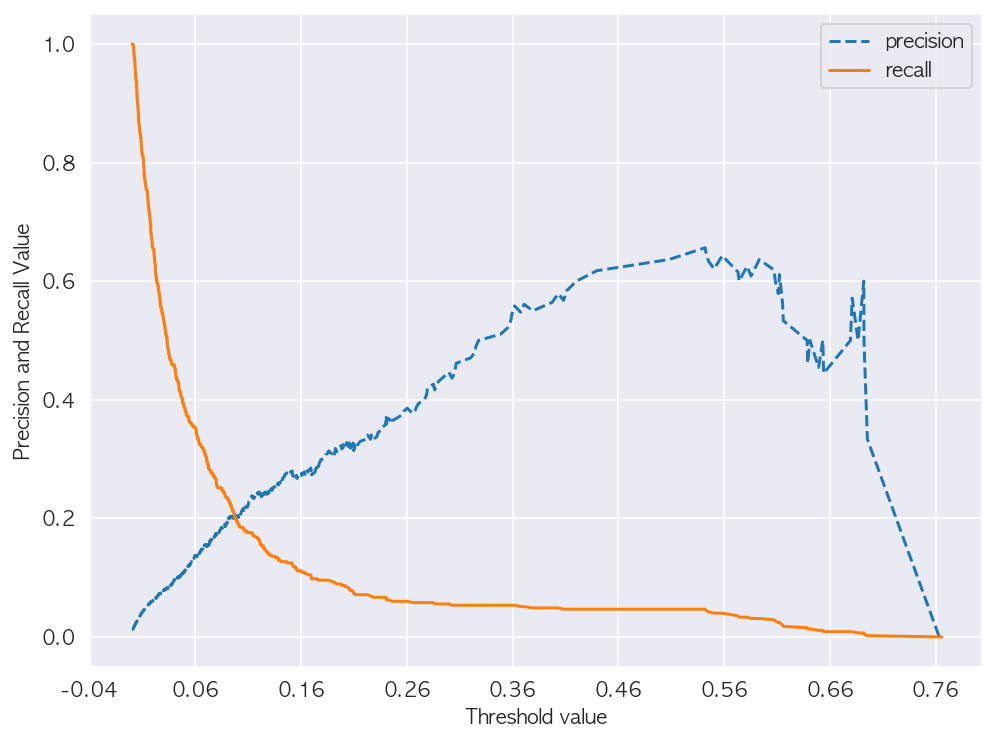

In [26]:
#모델 2-3. Precision-Recall Curve 시각화

from sklearn.metrics import precision_recall_curve

#레이블 값이 1일때의 예측확률을 추출
pred_proba_class1=lgbm_clf.predict_proba(X_test)[:,1]

#실제값 데이터 셋과 레이블 값이 1일때의 예측 확률을 precision_recall_curve 인자로 입력한다
precisions, recalls, thresholds= precision_recall_curve(y_test,pred_proba_class1)
print(f'변환된 분류 결정 임계값 배열의 shape:',thresholds.shape)

#임계값을 thresholds.shape[0] // 50으로 하자
thr_index= np.arange(0,thresholds.shape[0],thresholds.shape[0]//50)
# print(f'샘플 추출을 위한 임계값 배열의 index 20개 {thr_index}')
# print(f'샘플용 20개 임계값 {np.round(thresholds[thr_index],2)}')
#
# # thresholds.shape[0] // 50 스텝 단위로 추출된 임계값에 따른 정밀도와 재현율 값
# print(f'샘플 임계값별 정밀도 {np.round(precisions[thr_index],3)}')
# print(f'샘플 임계값별 재현율 {np.round(recalls[thr_index],3)}')

def precision_recall_curve_plot(y_test,pred_proba_c1):
    #threshold array와 이 threshold에 따른 정밀도, 재현율을 반환한다
    precisions, recalls, thresholds= precision_recall_curve(y_test,pred_proba_c1)

    #x축을 threshold값으로, y축을 정밀도, 재현율 값으로 각각 plot을 수행한다. 정밀도는 점선으로 표기한다
    plt.figure(figsize=(8,6))
    threshold_boundary= thresholds.shape[0]
    plt.plot(thresholds,precisions[0:threshold_boundary],linestyle='--',label='precision')
    plt.plot(thresholds,recalls[0:threshold_boundary],label='recall')

    #thresholds 값 X축의 scale을 0.1 단위로 변경한다
    start, end= plt.xlim()
    plt.xticks(np.round(np.arange(start,end,0.1),2))

    #x축, y축, label과 legend, 그리고 grid를 설정한다
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall Value')
    plt.legend(loc='best')
    plt.show()

precision_recall_curve_plot(y_test,lgbm_clf.predict_proba(X_test)[:,1])

#나중에 xgb_boost와 lgbm을 겹쳐서 성능차이가 얼마 안난다는것을 보여주는 것도 좋을듯